In [74]:
import pandas as pd
from glob import glob
from dateutil.relativedelta import relativedelta
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [75]:
results_files_paths = glob('./results/*.csv')
results_files_paths

['./results/shallow_nn.csv',
 './results/pca_with_10_components.csv',
 './results/extremely_randomized.csv',
 './results/pca_with_5_components.csv',
 './results/random_forest.csv',
 './results/pca_with_3_components.csv',
 './results/ols.csv',
 './results/boosted_regression_trees.csv',
 './results/deep_nn.csv',
 './results/ridge.csv']

In [84]:
def get_model_name_from_path(filepath):
    model_name_match = re.match('.+/(\w+).csv',filepath).group(1)
    return model_name_match

predictions_df = pd.DataFrame()
for pred_filepath in results_files_paths:
    model_name = get_model_name_from_path(pred_filepath)
    model_preds_df = pd.read_csv(pred_filepath)
    model_preds_df['Model'] = model_name
    predictions_df = pd.concat([predictions_df, model_preds_df], axis=0)

predictions_df['date'] = pd.to_datetime(predictions_df['date'])
predictions_df = predictions_df.set_index('date').sort_index()

from pandas.tseries.offsets import DateOffset
shifted_index = predictions_df.index + DateOffset(months=1)
predictions_df.index= shifted_index

In [90]:
dates_for_robust_check = pd.to_datetime(['1974-10-01', '2008-10-01'])
months_in_window = 12 # will output year before and year after the specified date

def get_time_window(df, date, months_in_window):
    start_date = date - relativedelta(months=months_in_window)
    end_date = date + relativedelta(months=months_in_window)
    return df.loc[start_date:end_date]




In [101]:
def plot_predictions(prediction_df, mark_date):
    # Warning FUNCTION GENERATETED BY AI
    sns.set_theme(style='darkgrid')

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the forecast line
    sns.lineplot(data=prediction_df, x=prediction_df.index, y='forecast', hue='Model', 
                 alpha=0.5,
                #  markers=True, 
                #  style='Model',
                marker='o',
                 ax=ax)

    # Plot the actuals line
    sns.lineplot(
        data=prediction_df, x=prediction_df.index, y='actual', label='Actuals',
        alpha=1,
        color='r',
        marker='o',
        # markers=True,
        # style="event" 
        # ms=5,
        ax=ax)

    # Set the labels and title
    ax.set_xlabel('Date')
    ax.set_ylabel('Values')
    ax.set_title('Forecast vs Actuals')
    plt.axvline(mark_date)
    # Display the plot
    # fig.savefig('./plots/test.pdf')
    plt.show()

In [92]:
from sklearn.metrics import mean_squared_error, r2_score

In [93]:
def get_metrics_zoomeed(df):
    def calc_metric(sub_df):
        res_df =  pd.Series([
            mean_squared_error(sub_df['actual'], sub_df['forecast']),
            r2_score(sub_df['actual'], sub_df['forecast'])

        ], index=['mse', 'r2'])
        return res_df
    return df.groupby('Model').apply(calc_metric)

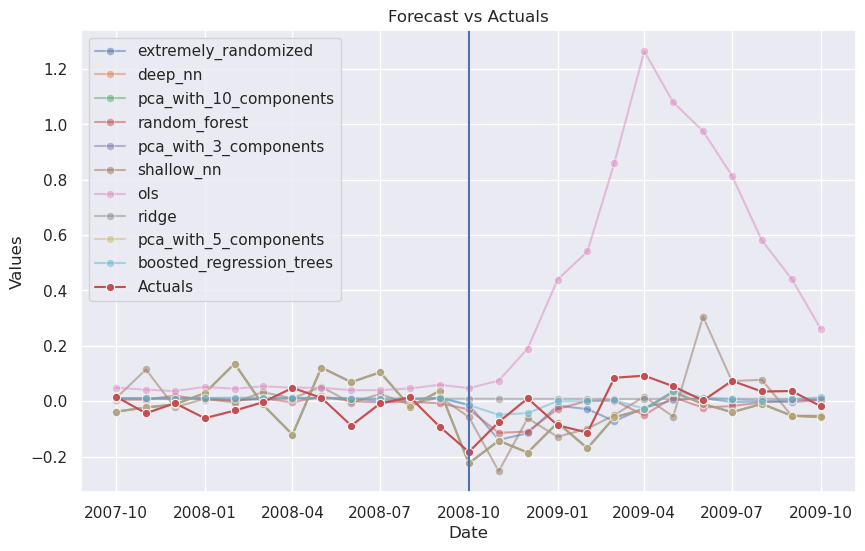

,Model,metric,value
0,boosted_regression_trees,mse,0.004558
8,ridge,mse,0.004855
7,random_forest,mse,0.004982
2,extremely_randomized,mse,0.005738
1,deep_nn,mse,0.009777
4,pca_with_10_components,mse,0.009777
5,pca_with_3_components,mse,0.009777
6,pca_with_5_components,mse,0.009777
9,shallow_nn,mse,0.009951
3,ols,mse,0.238214


In [102]:

event_df = get_time_window(predictions_df, dates_for_robust_check[1], months_in_window)
plot_predictions(event_df, dates_for_robust_check[1])
metrics_df = get_metrics_zoomeed(event_df).reset_index().melt(id_vars='Model', var_name='metric')
metrics_df.sort_values(['metric','value'])

# plt.savefig('./plots/robustness.pdf')

In [103]:
print(metrics_df.to_latex())

\begin{tabular}{lllr}
\toprule
 & Model & metric & value \\
\midrule
0 & boosted_regression_trees & mse & 0.004558 \\
1 & deep_nn & mse & 0.009777 \\
2 & extremely_randomized & mse & 0.005738 \\
3 & ols & mse & 0.238214 \\
4 & pca_with_10_components & mse & 0.009777 \\
5 & pca_with_3_components & mse & 0.009777 \\
6 & pca_with_5_components & mse & 0.009777 \\
7 & random_forest & mse & 0.004982 \\
8 & ridge & mse & 0.004855 \\
9 & shallow_nn & mse & 0.009951 \\
10 & boosted_regression_trees & r2 & -0.050801 \\
11 & deep_nn & r2 & -1.254050 \\
12 & extremely_randomized & r2 & -0.322713 \\
13 & ols & r2 & -53.917163 \\
14 & pca_with_10_components & r2 & -1.254050 \\
15 & pca_with_3_components & r2 & -1.254050 \\
16 & pca_with_5_components & r2 & -1.254050 \\
17 & random_forest & r2 & -0.148574 \\
18 & ridge & r2 & -0.119292 \\
19 & shallow_nn & r2 & -1.294172 \\
\bottomrule
\end{tabular}



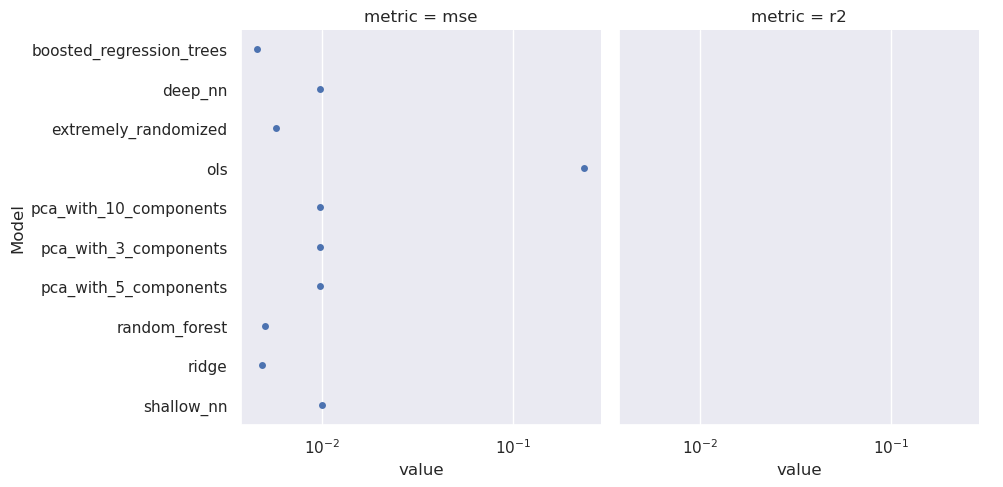

In [95]:
# metrics_df_trans = metrics_df.copy()
# metrics_df_trans['value'] = np.log(metrics_df_trans['value'])
sns.catplot(data=metrics_df, x='value', y='Model', col='metric')

plt.xscale('log')

In [24]:
def plot_multiple_predictions(prediction_dfs):
    """
    Plots multiple forecast and actuals lines from a list of DataFrames on the same plot.

    Args:
        prediction_dfs (list of tuples): A list where each element is a tuple containing a DataFrame and a label.
                                         The DataFrame should have columns 'forecast' and 'actual', and the label
                                         will be used to distinguish different predictions in the plot.
    """
    sns.set_theme(style='darkgrid')

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Iterate over the list of DataFrames and plot each one
    for prediction_df, label in prediction_dfs:
        # Plot the forecast line
        sns.lineplot(data=prediction_df, x=prediction_df.index, y='forecast', label=f'{label} Forecast', ax=ax)
        
        # Plot the actuals line
        sns.lineplot(data=prediction_df, x=prediction_df.index, y='actual', label=f'{label} Actuals', ax=ax, alpha=0.7)

    # Set the labels and title
    ax.set_xlabel('Date')
    ax.set_ylabel('Values')
    ax.set_title('Forecast vs Actuals for Multiple Models')

    # Display the plot
    plt.show()

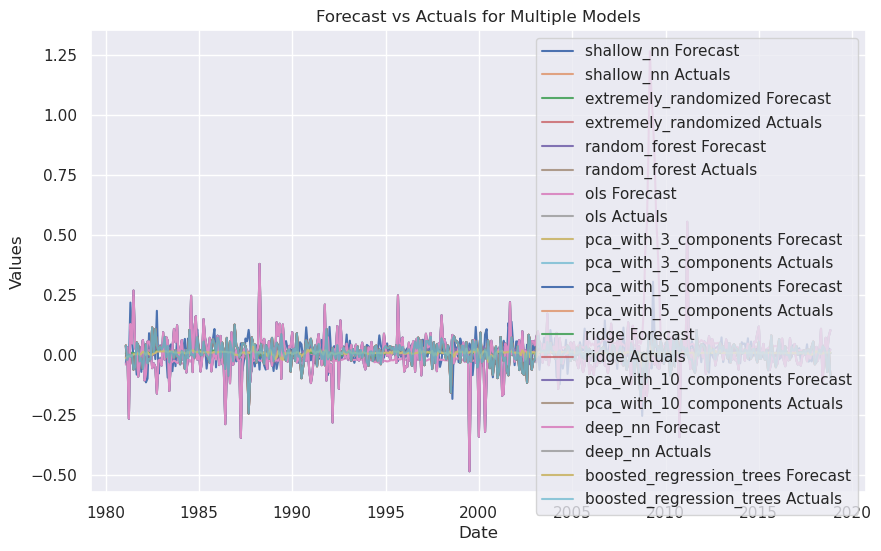

In [29]:
dfs = []
plots = ['random_forest']
for m in predictions_df.Model.unique():
    dfs.append((predictions_df[predictions_df['Model'] == m], m))
plot_multiple_predictions(dfs)

In [31]:
predictions_df.Model.unique()

array(['shallow_nn', 'extremely_randomized', 'random_forest', 'ols',
       'pca_with_3_components', 'pca_with_5_components', 'ridge',
       'pca_with_10_components', 'deep_nn', 'boosted_regression_trees'],
      dtype=object)

In [54]:
def plot_predictions_2(prediction_df, prediction_df_forest):
    # Warning FUNCTION GENERATETED BY AI
    sns.set_theme(style='darkgrid')

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the forecast line
    sns.lineplot(data=prediction_df, x=prediction_df.index, y='forecast', hue='Model', 
                 alpha=0.2,
                #  markers=True, 
                #  style='Model',
                # marker='o',
                 ax=ax)

    sns.lineplot(data=prediction_df_forest, x=prediction_df_forest.index, y='forecast', 
                 alpha=1,
                 color='g',
                #  markers=True, 
                #  style='Model',
                # marker='o',
                 ax=ax)
    # Plot the actuals line
    sns.lineplot(
        data=prediction_df, x=prediction_df.index, y='actual', label='Actuals',
        # alpha=1,
        color='r',
        # marker='o',
        # markers=True,
        # style="event" 
        # ms=5,
        alpha=0.5,
        ax=ax)

    # Set the labels and title
    ax.set_xlabel('Date')
    ax.set_ylabel('Values')
    ax.set_title('Forecast vs Actuals')
    # plt.axvline(mark_date)
    # Display the plot
    plt.show()

In [55]:
predictions_df

,actual,forecast,Model
date,,,
1981-02-01,0.039239,-0.033815,shallow_nn
1981-02-01,0.039239,-0.002567,extremely_randomized
1981-02-01,0.039239,-0.009194,random_forest
1981-02-01,0.039239,-0.039758,ols
1981-02-01,0.039239,0.029813,pca_with_3_components
...,...,...,...
2018-11-01,-0.094480,0.008848,extremely_randomized
2018-11-01,-0.094480,0.103546,pca_with_10_components
2018-11-01,-0.094480,0.021849,shallow_nn


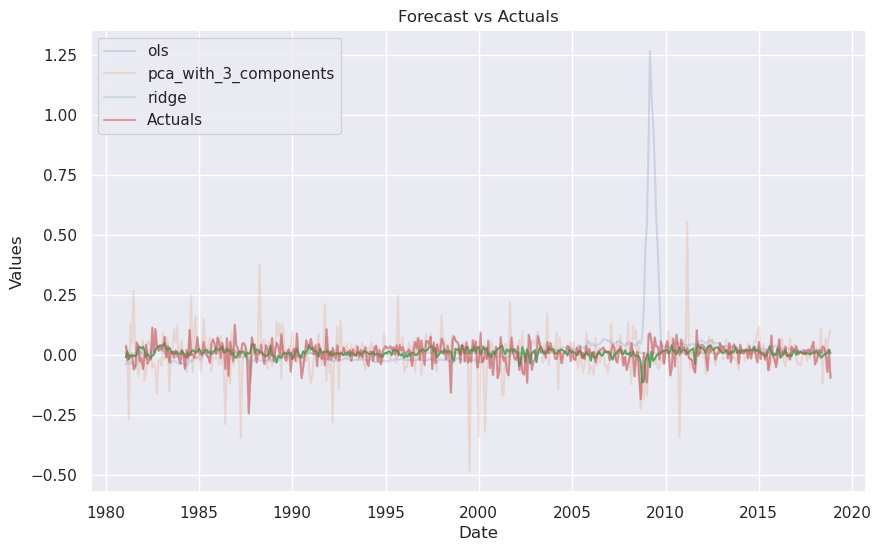

<Figure size 640x480 with 0 Axes>

In [57]:
models = [
    'ols',
    'pca_with_3_components',
    'ridge', 


]
  
plot_predictions_2(
    predictions_df[predictions_df.Model.isin(models)], 
                  predictions_df[predictions_df['Model'] == 'random_forest'] )
plt.savefig('./plots/random_forest.pdf')